## Import data, set logging level

In [1]:
from mne.datasets import multimodal
import mne
mne.set_log_level(verbose='CRITICAL')
import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))
from deepmeg.training.callbacks import Callback, EarlyStopping, L2Reg
from deepmeg.training.trainers import Trainer
from deepmeg.data.datasets import read_epochs_dataset, EpochsDataset
from deepmeg.preprocessing.transforms import zscore
import torch
import torch.nn as nn
from collections import defaultdict
from deepmeg.data.utils import make_train_and_val_loaders
from torch.utils.data import DataLoader, Dataset
from deepmeg.models.interpretable import LFCNN
from deepmeg.interpreters import LFCNNInterpreter
import torchmetrics
from deepmeg.training.callbacks import PrintingCallback
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
import matplotlib
import scipy as sp

## Split the dataset into train and test sets

In [2]:
dataset = EpochsDataset.load('../data/multimodal.pt')
train, test = torch.utils.data.random_split(dataset, [.7, .3])

## Create model, inheriting from BaseModel class

In [3]:
# very simple function to plot history of the model training

def plot_metrics(metrics: dict[str, np.ndarray]):
    plot_dict = defaultdict(dict)

    for metric, values in metrics.items():
        metric_data = metric.split('_')
        metric_name = '_'.join(metric_data[:-1])
        metric_kind = metric_data[-1]
        plot_dict[metric_name][metric_kind] = values

    for metric_name, kind_dict in plot_dict.items():
        legend = list()
        for metric_kind, kind in kind_dict.items():
            plt.plot(kind)
            legend.append(metric_kind)
        plt.title(metric_name)
        plt.legend(legend)
        plt.show()

In [37]:
from torch.autograd import Variable

class GRUCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True):
        super(GRUCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias

        self.x2h = nn.Linear(input_size, 3 * hidden_size, bias=bias)
        self.h2h = nn.Linear(hidden_size, 3 * hidden_size, bias=bias)

        self.reset_parameters()


    def reset_parameters(self):
        std = 1.0 / np.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, input_, hx=None):

        # Inputs:
        #       input: of shape (batch_size, input_size)
        #       hx: of shape (batch_size, hidden_size)
        # Output:
        #       hy: of shape (batch_size, hidden_size)

        if hx is None:
            hx = Variable(input_.new_zeros(input_.size(0), self.hidden_size))

        x_t = self.x2h(input_)
        h_t = self.h2h(hx)


        x_reset, x_upd, x_new = x_t.chunk(3, 1)
        h_reset, h_upd, h_new = h_t.chunk(3, 1)

        reset_gate = torch.sigmoid(x_reset + h_reset)
        update_gate = torch.sigmoid(x_upd + h_upd)
        # new_gate = torch.tanh(x_new + (reset_gate * h_new))
        new_gate = x_new + (reset_gate * h_new) # linear to be consistent with CSP

        hy = (1 - update_gate) * hx + update_gate * new_gate

        return hy


class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1, bias=True):
        super(GRU, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bias = bias

        self.rnn_cell_list = nn.ModuleList()

        self.rnn_cell_list.append(GRUCell(self.input_size,
                                          self.hidden_size,
                                          self.bias))
        for l in range(1, self.num_layers):
            self.rnn_cell_list.append(GRUCell(self.hidden_size,
                                              self.hidden_size,
                                              self.bias))


    def forward(self, input_, hx=None):

        # Input of shape (batch_size, seqence length, input_size)
        #
        # Output of shape (batch_size, output_size)

        if hx is None:
            h0 = Variable(torch.zeros(self.num_layers, input_.size(0), self.hidden_size))

        else:
            h0 = hx

        outs = []

        hidden = list()
        for layer in range(self.num_layers):
            hidden.append(h0[layer, :, :])

        for t in range(input_.size(1)):

            for layer in range(self.num_layers):

                if layer == 0:
                    hidden_l = self.rnn_cell_list[layer](input_[:, t, :], hidden[layer])
                else:
                    hidden_l = self.rnn_cell_list[layer](hidden[layer - 1], hidden[layer])

                hidden[layer] = hidden_l

            outs.append(hidden_l)

        # Take only last time step. Modify for seq to seq
        # out = outs[-1].squeeze()

        return torch.stack(outs, 1)

In [35]:
X.shape

torch.Size([1, 204, 301])

In [40]:
torch.permute(GRU(204, 16)(torch.permute(X, (0, 2, 1))), (0, 2, 1)).shape
# GRU(204, 16)(X).shape

torch.Size([1, 16, 301])

In [147]:
from deepmeg.models import BaseModel


class GRULFCNN(BaseModel):

    def __init__(
        self,
        n_channels: int,
        n_latent: int,
        n_times: int,
        filter_size: int,
        pool_factor: int,
        n_outputs: int
    ):
        super().__init__()
        self.pool_factor = pool_factor
        self.unmixing_layer = GRU(n_channels, n_latent)
        # self.unmixing_layer = nn.GRU(n_channels, n_latent, batch_first=True)
        self.temp_conv = nn.Conv1d(n_latent, n_latent, kernel_size=filter_size, bias=True, groups=n_latent, padding='same')
        final_out_features = (n_times//pool_factor)*n_latent if not n_times%pool_factor else (n_times//pool_factor + 1)*n_latent
        self.fc_layer = nn.Linear(final_out_features, n_outputs)


    def forward(self, x: torch.Tensor):
        x = torch.permute(x, (0, 2, 1)) # make it (batch_size, n_times, n_channels)
        x = self.unmixing_layer(x)#[0]
        x = torch.permute(x, (0, 2, 1))
        x = self.temp_conv(x)
        x = x[:, :, ::self.pool_factor].contiguous()
        x = torch.flatten(x, 1)
        return self.fc_layer(x)


class GRULFCNNr(BaseModel):

    def __init__(
        self,
        n_channels: int,
        n_times: int,
        n_latent: int,
        select_n_latent: int,
        filter_size: int,
        pool_factor: int,
        n_outputs: int
    ):
        super().__init__()
        self.pool_factor = pool_factor
        self.n_latent = n_latent
        self.unmixing_layer = GRU(n_channels, n_latent)
        self.select_n_latent = select_n_latent
        self.temp_conv = nn.Conv1d(self.select_n_latent, self.select_n_latent, kernel_size=filter_size, bias=True, groups=self.select_n_latent, padding='same')
        final_out_features = (n_times//pool_factor)*self.select_n_latent if not n_times%pool_factor else (n_times//pool_factor + 1)*self.select_n_latent
        self.fc_layer = nn.Linear(final_out_features, n_outputs)


    def forward(self, x: torch.Tensor):
        x = torch.permute(x, (0, 2, 1)) # make it (batch_size, n_times, n_channels)
        x = self.unmixing_layer(x)#[0]
        x = torch.permute(x, (0, 2, 1))
        x = x[:, :self.select_n_latent]
        x = self.temp_conv(x)
        x = x[:, :, ::self.pool_factor].contiguous()
        x = torch.flatten(x, 1)
        return self.fc_layer(x)

In [158]:
from deepmeg.training.callbacks import Callback


class IndependanceConstraint(Callback):
    def __init__(self, n_latent: int):
        self.n_latent = n_latent
        self.eye = torch.eye(self.n_latent)
        super().__init__()

    def set_trainer(self, trainer: 'Trainer'):
        super().set_trainer(trainer)
        self.model = self.trainer.model

    def on_loss_computed(self, X, Y, Y_pred, loss, is_training=True):

        if is_training:
            # x = self.model.unmixing_layer(X)
            x = torch.permute(X, (0, 2, 1)) # make it (batch_size, n_times, n_channels)
            x = self.model.unmixing_layer(x)#[0]
            x = torch.permute(x, (0, 2, 1))

            x = x.permute(1, 0, -1)
            x = x.reshape(x.shape[0], x.shape[1]*x.shape[2])
            s = torch.corrcoef(x)
            err = (((s - self.eye)**2)/self.n_latent**2).sum()
            # err = ((torch.abs(s - self.eye))/self.n_latent).sum()

            loss += err

        return loss


class WeightClipper(object):
    def __init__(self, model):
        self.model = model

    def __call__(self, module):
        self.model.temp_conv.weight -= self.model.temp_conv.weight.mean(-1, keepdim=True)


class TempConvAveClipping(Callback):
    def __init__(self):
        super().__init__()

    def set_trainer(self, trainer: Trainer):
        super().set_trainer(trainer)
        self.model = self.trainer.model
        self.clipper = WeightClipper(self.model)

    @torch.no_grad()
    def on_batch_end(
        self,
        Y: torch.Tensor,
        Y_pred: torch.Tensor,
        metrics: dict
    ):
        self.model.apply(self.clipper)


In [159]:
X, Y = next(iter(DataLoader(train, batch_size=1)))
X.shape, Y.shape

(torch.Size([1, 204, 301]), torch.Size([1, 8]))

## Compile the model

In [160]:
from deepmeg.models.interpretable import LFCNN

In [161]:
# model = GRULFCNN(
#     n_channels=204, # ~ number of channels (gradiometers)
#     n_latent=8, # ~ number of latent factors
#     n_times=301, # ~ number of samples in epoch after preprocessing
#     filter_size=50, # ~ FIR filter size
#     pool_factor=10, # ~ take each 10th sample from spatially filtered components
#     n_outputs=8 # ~ number of output classes (number of events in epochs)
# )
model = GRULFCNNr(
    n_channels=204, # ~ number of channels (gradiometers)
    n_latent=8, # ~ number of latent factors
    select_n_latent=4,
    n_times=301, # ~ number of samples in epoch after preprocessing
    filter_size=50, # ~ FIR filter size
    pool_factor=10, # ~ take each 10th sample from spatially filtered components
    n_outputs=8 # ~ number of output classes (number of events in epochs)
)

optimizer = torch.optim.Adam
loss = torch.nn.BCEWithLogitsLoss()
metric = torchmetrics.functional.classification.binary_accuracy

model.compile(
    optimizer,
    loss,
    metric,
    callbacks=[
        PrintingCallback(), # print ongoing training history
        IndependanceConstraint(8),
        EarlyStopping(patience=15, monitor='loss_val', restore_best_weights=True), # perform early stopping with restoring best weights
        L2Reg(
            [
                # 'unmixing_layer.weight', 
                'temp_conv.weight',
            ], lambdas=.01
        ) # l2 regularization for weights of spatial- and temporal filtering layers
    ]
)

In [162]:
if hasattr(sys.stdout, 'file'):
    sys.stdout = sys.stdout.file

## Training the model

Epoch 0:  loss_train:  0.7903   |    binary_accuracy_train:  0.5239   |    loss_val:  0.7377   |    binary_accuracy_val:  0.5577
Epoch 1:  loss_train:  0.7436   |    binary_accuracy_train:  0.5576   |    loss_val:  0.7086   |    binary_accuracy_val:  0.5860
Epoch 2:  loss_train:  0.7061   |    binary_accuracy_train:  0.5901   |    loss_val:  0.6822   |    binary_accuracy_val:  0.6088
Epoch 3:  loss_train:  0.6714   |    binary_accuracy_train:  0.6318   |    loss_val:  0.6546   |    binary_accuracy_val:  0.6350
Epoch 4:  loss_train:  0.6357   |    binary_accuracy_train:  0.6722   |    loss_val:  0.6237   |    binary_accuracy_val:  0.6662
Epoch 5:  loss_train:  0.5978   |    binary_accuracy_train:  0.7111   |    loss_val:  0.5895   |    binary_accuracy_val:  0.7026
Epoch 6:  loss_train:  0.5587   |    binary_accuracy_train:  0.7493   |    loss_val:  0.5538   |    binary_accuracy_val:  0.7437
Epoch 7:  loss_train:  0.5210   |    binary_accuracy_train:  0.7724   |    loss_val:  0.5198   | 

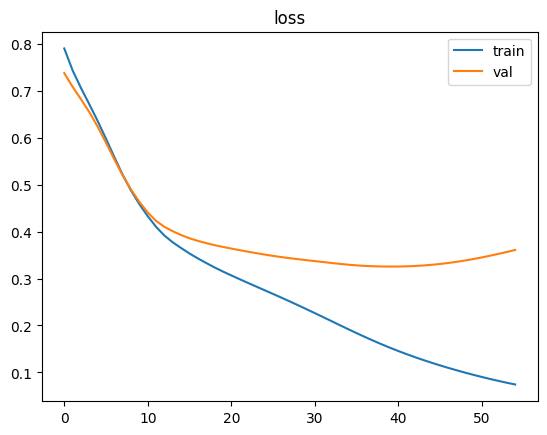

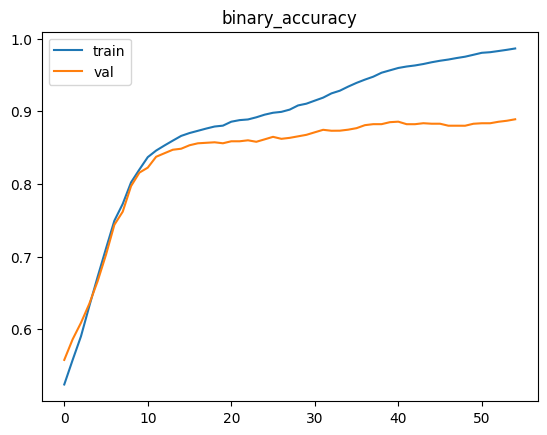

In [163]:
history = model.fit(train, n_epochs=150, batch_size=200, val_batch_size=60)
plot_metrics(history)

## Evaluate the model

In [164]:
train_result = model.evaluate(train)
result = model.evaluate(test)

for measure, value in train_result.items():
    print(f'train_{measure}: {value}')

for measure, value in result.items():
    print(f'{measure}: {value}')

train_loss: 0.1813509531996467
train_binary_accuracy: 0.9454545432871039
loss: 0.3080036992376501
binary_accuracy: 0.8851461031220176


In [165]:
X, Y = next(iter(DataLoader(test, batch_size=len(test))))

In [166]:
sources = torch.permute(X, (0, 2, 1)) # make it (batch_size, n_times, n_channels)
sources = model.unmixing_layer(sources)#[0]
sources = torch.permute(sources, (0, 2, 1)).detach().numpy()

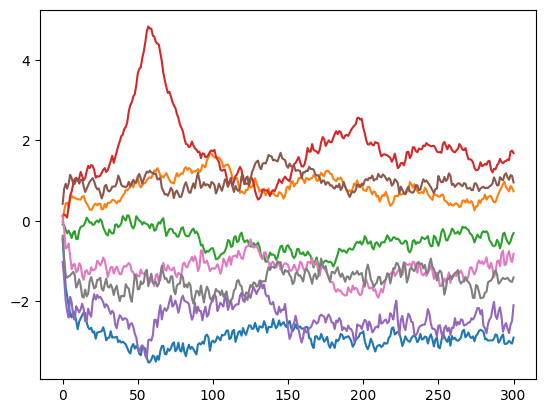

In [167]:
plt.plot(sources.mean(0).T)

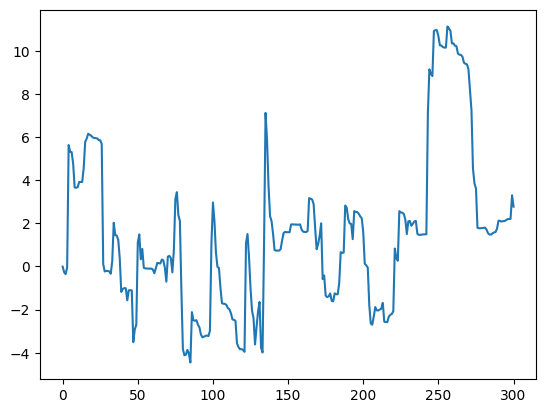

In [202]:
plt.plot(sources[4][3].T)

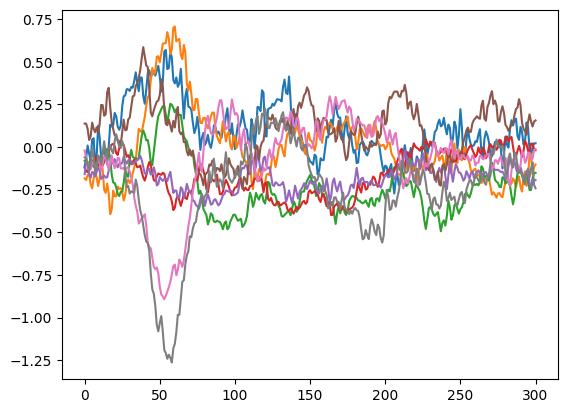

In [89]:
sources = model.unmixing_layer(X).detach().numpy()

plt.plot(sources.mean(0).T)

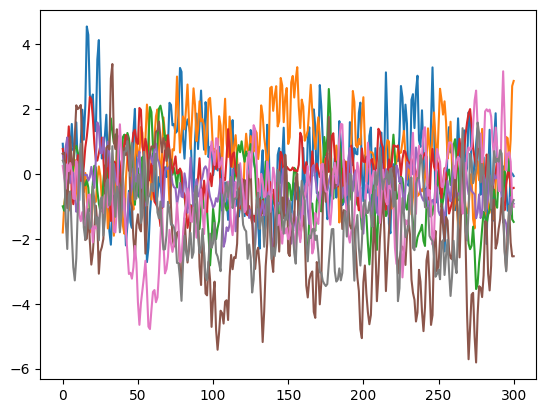

In [90]:
plt.plot(sources[0].T)

## Make a prediction

#### Take a random sample from the test set

In [18]:
i = np.random.randint(len(test))
print(f'Sample {i}')
x, y = test[i]
y = y.numpy()

# unsqueezing due to the first dimension must be batch size
x = torch.unsqueeze(x, 0)

Sample 272


#### Make a prediction, print the predicted value and the actual label

In [19]:
y_pred = np.round(torch.squeeze(model(x)).detach().numpy(), 2)

print(f'Prediction: {" | ".join([str(sample).center(5, " ") for sample in y_pred])}')
print(f'Actual:     {" | ".join([str(sample).center(5, " ") for sample in y])}')

Prediction: -3.74 | -6.82 | -6.93 |  3.41 | -7.61 | -9.65 | -6.59 | -11.13
Actual:      0.0  |  0.0  |  0.0  |  1.0  |  0.0  |  0.0  |  0.0  |  0.0 


## Model interpretation

In [20]:
interpreter = LFCNNInterpreter(model, test, info)

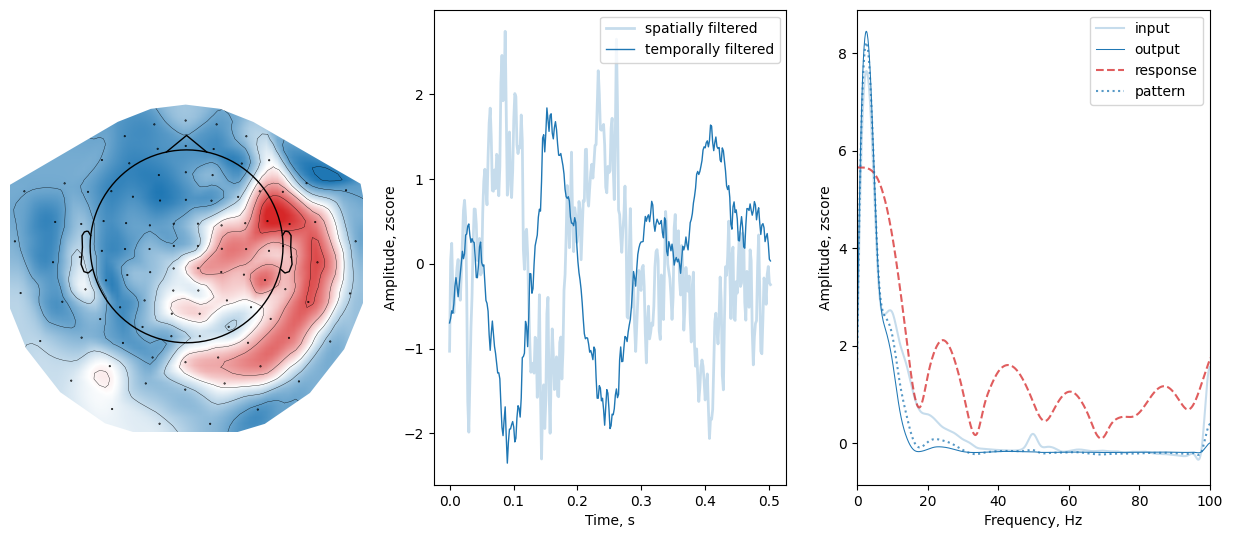

In [21]:
fig = interpreter.plot_branch(0, ['input', 'output', 'response', 'pattern'])